<a href="https://colab.research.google.com/github/raykeat/Text-Classification-Sentiment-Analysis-of-Wine-Reviews-with-TensorFlow/blob/main/Tensorflow_text_classification_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("wine-reviews.csv", usecols = ["country","description","points","price","variety","winery"])

#or

# df = pd.read_csv("wine-reviews.csv").drop(["Unnamed: 0","designation","province","region_1","region_2","taster_name","taster_twitter_handle","title"],axis=1)
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


Removing Rows where description or points column is empty and plotting histogram of frequency of different points

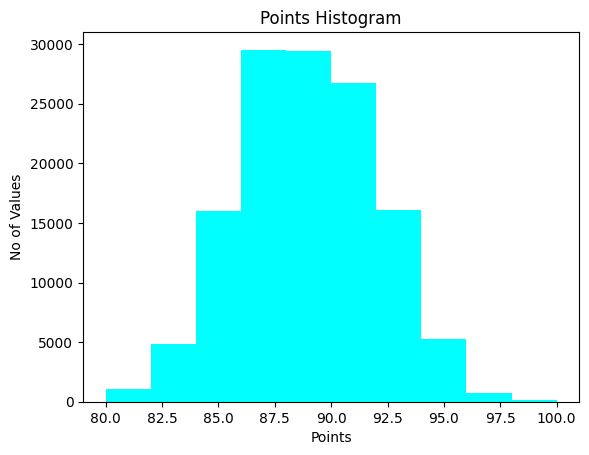

In [3]:
#method that removes missing or null values from a dataset, "subset" specifies columns to consider when dropping rows or columns
df = df.dropna(subset=["description","points"])

#plotting a histogram
plt.hist(df["points"],color='cyan')
plt.title("Points Histogram")
plt.ylabel("No of Values")
plt.xlabel("Points")
plt.show()

Feature Engineering - creating a new binary output label based on the points output column. Essentially mapping points>=90 to an output label of 1 and points<90 to an output label of 0

In [4]:
#creating a label column containing 0 and 1s
df["label"] = (df.points>=90).astype(int)

df = df[["description","points","label"]]

#separating the train, validation and test datasets
train, validation, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

Converting Pandas DataFrame into TensorFlow Dataset object.
This is necessary to prepare data in format that can be used efficiently by TensorFlow, especially when working with textual data in the case of NLP

In [5]:
# function that takes a pandas dataframe as input and returns a TensorFlow dataset object.
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
  labels = df.pop('label')  # Extract the 'label' column from the DataFrame and remove it from df
  df = df["description"]  # Keep only the 'description' column in df
  ds = tf.data.Dataset.from_tensor_slices((df, labels))  # Create a TensorFlow Dataset from the description data and labels
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))  # Shuffle the dataset if shuffle is True
  ds = ds.batch(batch_size)  # Create batches of the dataset with the specified batch size
  ds = ds.prefetch(tf.data.AUTOTUNE)  # Prefetch data for better performance
  return ds  # Return the processed TensorFlow Dataset


In [6]:
train_tf_dataset = df_to_dataset(train)
val_tf_dataset = df_to_dataset(validation)
test_tf_dataset = df_to_dataset(test)

# TensorFlow FeedForward Neural Network Architecture with Token Based Text Embedding

A token-based text embedding is a technique used to represent textual data as vectors of numerical values in a way that captures the semantic meaning of the text. In this approach, each word or subword in the text is represented by a fixed-size vector, which is learned from a large corpus of text using deep learning algorithms such as neural networks.

The process of generating text embeddings typically involves the following steps:

Tokenization: The text is split into individual words or subwords, depending on the tokenizer used.

Indexing: Each word or subword is assigned a unique integer index that maps to a vector in the embedding matrix.

Embedding: The embedding matrix is initialized with random values and updated during training to optimize a loss function that measures the quality of the embeddings. The goal is to learn a set of embedding vectors that capture the semantic relationships between words in the text.


TensorFlow example text classification with movie reviews documentation: https://www.tensorflow.org/hub/tutorials/tf2_text_classification

TensorFlow Hub Model for text embedding (nnlm-en-dim50/2): https://tfhub.dev/google/nnlm-en-dim50/2

First Keras layer that uses a TensorFlow Hub model to embed the sentences: This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using (google/nnlm-en-dim50/2) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
#This pre-trained text embedding is used as first layer of neural network, converting descriptions into embeddings vectors
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

hub_layer(list(train_tf_dataset)[0][0])


<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.40730077, -0.389088  , -0.13958672, ..., -0.09506935,
        -0.07809962,  0.22596331],
       [ 0.46935362, -0.27004373, -0.15425786, ...,  0.03911992,
        -0.06013145,  0.23949085],
       [ 0.44627008, -0.17253546, -0.01537439, ...,  0.09055022,
        -0.30940676,  0.08715522],
       ...,
       [ 0.10406947, -0.26482335,  0.18094303, ...,  0.09522269,
        -0.00907054,  0.04241081],
       [ 0.02250067, -0.34525156,  0.12420916, ...,  0.07595891,
        -0.0269012 , -0.0678947 ],
       [ 0.3068943 , -0.14828463, -0.01070997, ...,  0.01061942,
        -0.12123633, -0.08146781]], dtype=float32)>

Defining remaining layers of Neural Network Architecture

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


Compiling and Training the Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tf.keras.metrics.Recall()])

#Training the model using training TensorFlow dataset across 5 epochs.
#While training, monitor the model's loss, accuracy and recall on the validation dataset:
history = model.fit(train_tf_dataset, epochs=5, validation_data=val_tf_dataset)


Epoch 1/5
102/102 [==============================] - 169s 2s/step - loss: 0.6113 - accuracy: 0.6532 - recall: 0.2581 - val_loss: 0.4808 - val_accuracy: 0.7839 - val_recall: 0.7139
Epoch 2/5
102/102 [==============================] - 143s 1s/step - loss: 0.4574 - accuracy: 0.7945 - recall: 0.7179 - val_loss: 0.3990 - val_accuracy: 0.8159 - val_recall: 0.7624
Epoch 3/5
102/102 [==============================] - 154s 2s/step - loss: 0.3919 - accuracy: 0.8346 - recall: 0.7743 - val_loss: 0.3817 - val_accuracy: 0.8239 - val_recall: 0.7752
Epoch 4/5
102/102 [==============================] - 162s 2s/step - loss: 0.3581 - accuracy: 0.8509 - recall: 0.7917 - val_loss: 0.3767 - val_accuracy: 0.8255 - val_recall: 0.7982
Epoch 5/5
102/102 [==============================] - 164s 2s/step - loss: 0.3353 - accuracy: 0.8610 - recall: 0.7996 - val_loss: 0.3753 - val_accuracy: 0.8278 - val_recall: 0.7924


Evaluating Model on Test TensorFlow Dataset

In [ ]:
test_loss, test_accuracy, test_recall = model.evaluate(test_tf_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Recall: {test_recall}")

13/13 [==============================] - 3s 252ms/step - loss: 0.3945 - accuracy: 0.8279 - recall: 0.7796
Test Loss: 0.39454707503318787
Test Accuracy: 0.8278965950012207
Test Recall: 0.7795742750167847


# Plotting graphs of accuracy, loss and recall over time during model training process

In [ ]:
#Access model training history
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

In [ ]:
train_acc = history_dict['accuracy']
train_loss = history_dict['loss']
train_recall = history_dict['recall']

val_acc = history_dict['val_accuracy']
val_loss = history_dict['val_loss']
val_recall = history_dict['val_recall']

epochs = range(1,len(train_acc)+1)

Training and Validation Loss over time

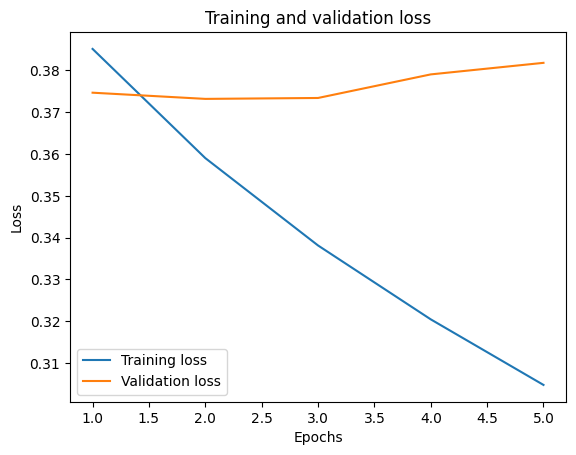

In [ ]:
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and Validation Accuracy over time

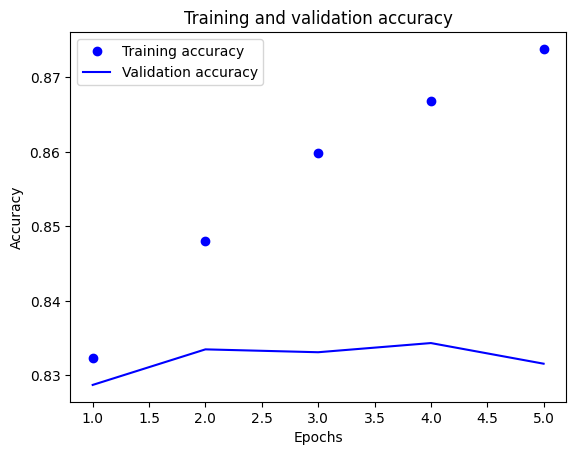

In [ ]:
# "bo" is for "blue dot"
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training and Validation Recall over time

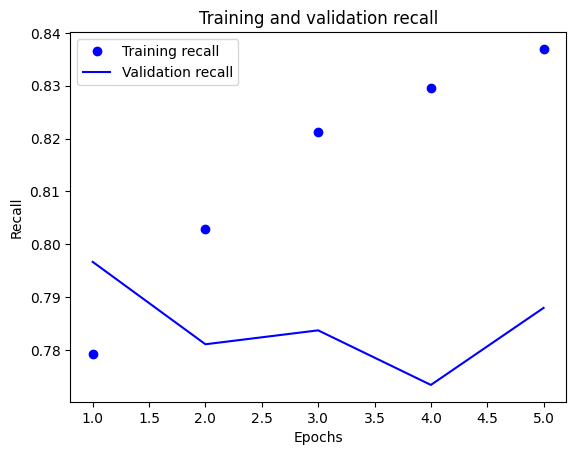

In [ ]:
# "bo" is for "blue dot"
plt.plot(epochs, train_recall, 'bo', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

Notice the training loss decreases with each epoch and the training accuracy and recall increase with each epoch. But this isn't the case for the validation dataset, indicating overfitting: where the model performs better on the training data than it does on data it has never seen before.

# LSTM Recurrent Neural Network

LSTM stands for Long Short-Term Memory, and it's a type of recurrent neural network (RNN) architecture designed to handle sequences and time-dependent data. LSTMs are particularly effective in capturing long-range dependencies in sequential data, which refer to relationships or patterns that exist between elements of the sequence that are far apart from each other.

Traditional RNNs struggle with capturing such long-range dependencies due to the vanishing gradient problem. As the sequence length increases, the gradients that backpropagate through the network can become very small, leading to difficulties in learning relationships that are distant in time. LSTMs were designed to address this issue by incorporating memory cells and gating mechanisms that allow them to selectively remember or forget information over extended periods, enabling them to capture dependencies even when they span a long sequence.

TensorFlow Text Classification with Recurrent Neural Networks documentation: https://www.tensorflow.org/text/tutorials/text_classification_rnn

Creating Text Encoder using TextVectorization Layer to process text before it can be used in Model (converts raw text to integer sequences)

In [7]:
#size of vocabulary used for tokenization, in this case will keep track of 2000 most frequent words from my text data
VOCAB_SIZE = 2000

#converts raw text into integer sequences by tokenizing the text (eg splitting sentences into words/smaller token units)
#and mapping tokens to integer indices based on a learned vocabulary.
encoder = tf.keras.layers.TextVectorization(
    #sets the maximum number of tokens (words) to keep in the vocabulary.
    max_tokens=VOCAB_SIZE)

#Adapting the Encoder to the Training Data, encoder will analyze the training data, tokenize the text, and build the vocabulary
encoder.adapt(train_tf_dataset.map(lambda text, label: text))

Recurrent Neural Network Architecture

In [8]:
model = tf.keras.Sequential([
    encoder,

    #embedding layer converts integer sequences (generated by the TextVectorization/Encoder layer above) into dense vector representations called embeddings, which capture semantic relationships between words
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle variable sequence lengths (padding tokens/0s are added
        #to shorter sequences to ensure all integer sequences have the same length,
        #but the zeros (padding tokens) are ignored during the computation of embeddings, so that padding tokens dont affect semantic meaning)
        mask_zero=True),

    #A bidirectional LSTM processes sequences in both forward and backward directions, capturing contextual information from both sides of the sequence.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compiling and training the model

In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_tf_dataset, epochs=5,
                    validation_data = val_tf_dataset,
                   )

Epoch 1/5
102/102 [==============================] - 171s 2s/step - loss: 0.4705 - accuracy: 0.7598 - val_loss: 0.3552 - val_accuracy: 0.8412
Epoch 2/5
102/102 [==============================] - 158s 2s/step - loss: 0.3457 - accuracy: 0.8431 - val_loss: 0.3530 - val_accuracy: 0.8418
Epoch 3/5
102/102 [==============================] - 158s 2s/step - loss: 0.3339 - accuracy: 0.8484 - val_loss: 0.3460 - val_accuracy: 0.8440
Epoch 4/5
102/102 [==============================] - 161s 2s/step - loss: 0.3277 - accuracy: 0.8515 - val_loss: 0.3536 - val_accuracy: 0.8412
Epoch 5/5
102/102 [==============================] - 156s 2s/step - loss: 0.3235 - accuracy: 0.8540 - val_loss: 0.3484 - val_accuracy: 0.8417


Evaluating Model on test dataset

In [10]:
test_loss, test_accuracy = model.evaluate(test_tf_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 6s 480ms/step - loss: 0.3468 - accuracy: 0.8420
Test Loss: 0.3467594385147095
Test Accuracy: 0.8419756889343262


Plotting graphs of accuracy and loss over time during model training

In [11]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.47780628949403764)

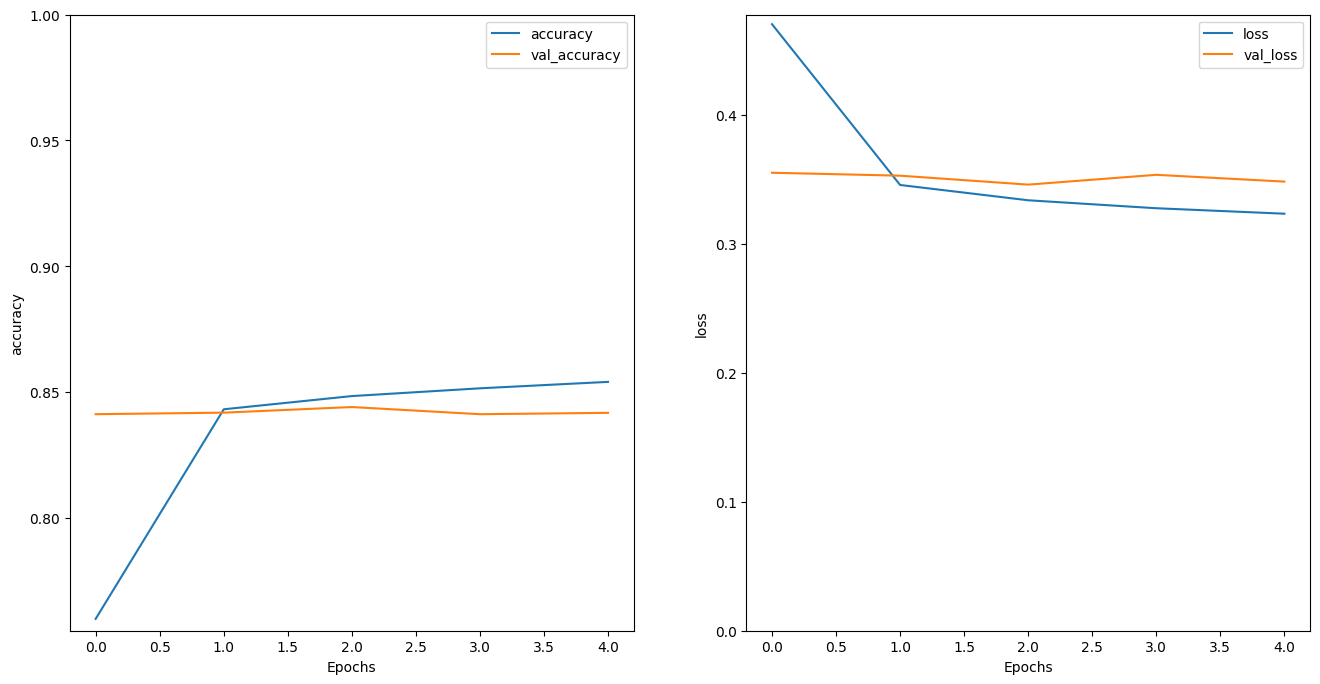

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Web Scraping to obtain wine blog posts from www.vinography.com



Using Beautiful Soup to obtain all the Wine Articles' Links

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.vinography.com/category/wine-reviews"
response = requests.get(url)
# Check the 'Content-Type' header for the encoding
# content_type = response.headers.get('Content-Type')
# encoding = content_type.split('charset=')[-1]
# print("Encoding:", encoding)
soup = BeautifulSoup(response.text, 'html.parser')

article_links = []

# Find all <h2> tags
h2_tags = soup.find_all('h2')

# Iterate through the <h2> tags and find the <a> tags within each <h2>
for h2_tag in h2_tags:
    # Find all <a> tags within the current <h2> tag
    a_tags_within_h2 = h2_tag.find_all('a')

    # Append the <a> tags found within the <h2>
    for a_tag in a_tags_within_h2:
        article_links.append(a_tag)

article_links

[<a data-wpel-link="internal" href="https://www.vinography.com/2023/09/vinography-unboxed-week-of-8-27-23">Vinography Unboxed: Week of 8/27/23</a>,
 <a data-wpel-link="internal" href="https://www.vinography.com/2023/08/ultramarine-californias-first-cult-sparkling-wine">Ultramarine: California’s First Cult Sparkling Wine</a>,
 <a data-wpel-link="internal" href="https://www.vinography.com/2023/08/vinography-unboxed-week-of-8-20-23">Vinography Unboxed: Week of 8/20/23</a>,
 <a data-wpel-link="internal" href="https://www.vinography.com/2023/08/vinography-unboxed-week-of-8-13-23">Vinography Unboxed: Week of 8/13/23</a>,
 <a data-wpel-link="internal" href="https://www.vinography.com/2023/08/santa-barbaras-sta-rita-hills">Santa Barbara’s Sta. Rita Hills</a>,
 <a data-wpel-link="internal" href="https://www.vinography.com/2023/08/surprising-santa-barbara">Surprising Santa Barbara</a>,
 <a data-wpel-link="internal" href="https://www.vinography.com/2023/08/vinography-unboxed-week-of-8-6-23">Vinog

Getting Article Content/Data from Article Links

In [14]:

articles_data = []

article=[]

for link in article_links:
    article_url = link['href']
    article_response = requests.get(article_url)
    article_soup = BeautifulSoup(article_response.text, 'html.parser')
    article_content = article_soup.find_all('p')
    for para in article_content:
        article.append(para.get_text())
    articles_data.append(article.copy())
    article=[]

articles_data[0]

['a wine blog',
 'Hello and welcome to my weekly dig through the pile of wine samples that show up asking to be tasted. I’m pleased to bring you the latest installment of Vinography Unboxed, where I highlight some of the better bottles that have crossed my doorstep recently.',
 'This past week included a bright and stony Sauvignon Blanc from Trois Noix wines in Napa, which is admirable for its slightly more austere approach to the grape which reminds me of the more typical European interpretation of the variety.',
 'I’m always excited to receive the wines from Can Sumoi, a natural wine project by Raventos i Blanc, based on the revitalization of an old farm in the Penedes region of Spain and its indigenous grape varieties. These wines are made with minimal sulfur additions, organically farmed grapes, and yet they’re wonderfully clean and pure. They also come in cute, squat bottles that are probably a nightmare to put into a rack, but look pretty neat.',
 'I’ve got another Armenian wine 

Cleaning up Article Data: removing unwanted paragraphs, extra whitespaces and combining paragraphs for an article into a single string

In [17]:
# Define keywords that indicate unwanted paragraphs
unwanted_keywords = ["a wine blog", "welcome to my weekly dig", "cookie", "privacy", "advertisement", "tags", "essence of wine", "free aroma card", "weekly update", "no thanks", "click to buy", "click here to sign up"]

# Clean up the articles_data list
cleaned_articles_data = []

for article in articles_data:
    # Filter out unwanted paragraphs and remove extra whitespace
    cleaned_article = [para.strip() for para in article if not any(keyword in para.lower() for keyword in unwanted_keywords)]

    # Remove empty paragraphs
    cleaned_article = [para for para in cleaned_article if para]

    # Join the cleaned paragraphs into a single text
    cleaned_article_text = ' '.join(cleaned_article)

    #decoding text using unidecode library
    #!pip install unidecode

    from unidecode import unidecode
    cleaned_articles_data.append(unidecode(cleaned_article_text))

cleaned_articles_data[4]

"If there is one part of Santa Barbara County that most embodies everything that makes the region special, it's the Sta Rita Hills American Viticultural Area (always appearing as Sta Rita Hills on wine labels thanks to a compromise made with Chilean producer Santa Rita). It fully deserves its own tasting article both because its wines alone made up nearly half of those I tasted in my recent survey of Santa Barbara County wines, but also because the region itself stands apart both literally and figuratively from the other AVAs in Santa Barbara County. Far out on the western edge of the Santa Ynez Valley, the Sta Rita Hills AVA is actually comprised of two separate valleys sandwiched between three sets of hills, like two slices of luncheon meat alternating with three slices of bread. These two valleys, oriented directly west-to-east thanks to the region's unique tectonic past, funnel extremely cold marine air in the form of wind and fog towards warmer inland valleys to the east, creating

Writing the Cleaned Articles Data List into a CSV File

In [19]:
import csv


# Define the CSV file name
csv_file_name = "wine_articles.csv"

# Open the CSV file in write mode
with open(csv_file_name, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    # Write a header row if needed
    # writer.writerow(['Title', 'Content'])

    # Iterate through your cleaned article data and write each row to the CSV file
    for article_text in cleaned_articles_data:
        writer.writerow([article_text])

print(f"CSV file '{csv_file_name}' has been created with the cleaned article data.")


CSV file 'wine_articles.csv' has been created with the cleaned article data.


#Using Trained TensorFlow Model to carry out text classification/sentiment analysis of real world wine articles we just scraped from vinography.com


In [20]:
import numpy as np
import pandas as pd

df = pd.read_csv("wine_articles.csv")
df

,"This past week included a bright and stony Sauvignon Blanc from Trois Noix wines in Napa, which is admirable for its slightly more austere approach to the grape which reminds me of the more typical European interpretation of the variety. I'm always excited to receive the wines from Can Sumoi, a natural wine project by Raventos i Blanc, based on the revitalization of an old farm in the Penedes region of Spain and its indigenous grape varieties. These wines are made with minimal sulfur additions, organically farmed grapes, and yet they're wonderfully clean and pure. They also come in cute, squat bottles that are probably a nightmare to put into a rack, but look pretty neat. I've got another Armenian wine to share with you this week, from producer Van Ardi, begun by a public accountant from Los Angeles who decided to return to his homeland and make wine. It's a lovely interpretation of the native Areni Noir grape with a little age on it. I also got the latest release from legendary Montalcino producer Biondi-Santi this week. Their 2020 Rosso di Montalcino is elegant and refined, and while it may not have the profundity of Brunello, it's still delicious and will likely age beautifully. It's also a darn sight cheaper than the pricey and hard-to-find Brunello. Lastly, I've got a couple of rich reds from Peter Mathis at Mathis Wine, who focuses on making wines from Sonoma Valley. For those looking for robust and powerful red wines, you'll enjoy both his Grenache and his unusual blend of Petite Sirah, Grenache and other grapes. Notes on all these below. 2022 Can Sumoi Garnaxta Blanca, SpainPale blonde in color, this wine smells of ripe golden apples and white flowers. In the mouth, slightly melon-like flavors mix with white flowers and golden apples as hints of citrus pith emerge in the finish. Bright and juicy thanks to very good acidity. 12.5% alcohol. Certified organic. Score: between 8.5 and 9. Cost: $?? 2019 Mathis Wines ""Uberblend"" Red Blend, Sonoma Valley, CaliforniaVery dark garnet in color, this wine smells of chocolate-covered strawberries. In the mouth, rich strawberry and black cherry flavors mix with a touch of mulling spice and dried herbs. Lightly grippy tannins grab the edge of the palate, but good acidity keeps things dynamic. Notes of oak linger in the finish. The wine is a blend of 44% Petite Sirah, 33% Grenache, 13% Carignane and 10% Alicante Bouschet. 14.9% alcohol. Packaged in an unnecessarily heavy bottle weighing 1.54 kg when full. Score: around 8.5. Cost: $30."
0,"How exclusive is Ultramarine, the single-viney..."
1,This week featured a number of spectacular win...
2,This week features a number of interesting Cal...
3,If there is one part of Santa Barbara County t...
4,Santa Barbara was launched into the consciousn...
5,This week we've got a bunch of Chenin Blanc to...
6,This week included a lot of refreshing wines o...
7,"For many people in the world of wine, Nicolas ..."
8,For those of you who are (apparently like the ...
9,This week included a whole bunch of pink wines...


Converting pandas dataframe to TensorFlow Dataset Object. This is necessary to prepare data in format that can be used efficiently by TensorFlow, especially when working with textual data in the case of NLP

In [21]:
import tensorflow as tf

# function that takes a pandas dataframe as input and returns a TensorFlow dataset object.
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
  ds = tf.data.Dataset.from_tensor_slices(df)  # Create a TensorFlow Dataset from the description data in dataframe
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))  # Shuffle the dataset if shuffle is True
  ds = ds.batch(batch_size)  # Create batches of the dataset with the specified batch size
  ds = ds.prefetch(tf.data.AUTOTUNE)  # Prefetch data for better performance
  return ds  # Return the processed TensorFlow Dataset

In [22]:
tf_dataset = df_to_dataset(df)
tf_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name=None)>

Using trained LSTM RNN model to predict labels for unlabeled wine articles

In [23]:
#Using trained LSTM RNN model to predict labels for unlabeled wine articles
predictions = model.predict(tf_dataset)
predictions

1/1 [==============================] - 8s 8s/step


array([[0.9716648 ],
       [0.9344603 ],
       [0.8477233 ],
       [0.90374637],
       [0.94272774],
       [0.81069064],
       [0.91141826],
       [0.9034606 ],
       [0.89320034],
       [0.9388793 ],
       [0.9828142 ],
       [0.958201  ],
       [0.82818395],
       [0.9402902 ],
       [0.9803822 ],
       [0.5691161 ],
       [0.9368088 ],
       [0.75871795]], dtype=float32)

In [24]:
#adding column name for the articles df
df.columns = ['Article Content']
articles_content_df = df.copy()
articles_content_df

,Article Content
0,"How exclusive is Ultramarine, the single-viney..."
1,This week featured a number of spectacular win...
2,This week features a number of interesting Cal...
3,If there is one part of Santa Barbara County t...
4,Santa Barbara was launched into the consciousn...
5,This week we've got a bunch of Chenin Blanc to...
6,This week included a lot of refreshing wines o...
7,"For many people in the world of wine, Nicolas ..."
8,For those of you who are (apparently like the ...
9,This week included a whole bunch of pink wines...


In [25]:
predictions_df = pd.DataFrame({'Score': predictions.flatten()})
predictions_df

,Score
0,0.971665
1,0.934460
2,0.847723
3,0.903746
4,0.942728
5,0.810691
6,0.911418
7,0.903461
8,0.893200
9,0.938879


Concatenating Articles Content Dataframe and Predictions Dataframe into a single Result Dataframe, and then writing it to a csv file


In [26]:
result_df = pd.concat([articles_content_df.squeeze(), predictions_df], axis=1)
result_df

,Article Content,Score
0,"How exclusive is Ultramarine, the single-viney...",0.971665
1,This week featured a number of spectacular win...,0.934460
2,This week features a number of interesting Cal...,0.847723
3,If there is one part of Santa Barbara County t...,0.903746
4,Santa Barbara was launched into the consciousn...,0.942728
5,This week we've got a bunch of Chenin Blanc to...,0.810691
6,This week included a lot of refreshing wines o...,0.911418
7,"For many people in the world of wine, Nicolas ...",0.903461
8,For those of you who are (apparently like the ...,0.893200
9,This week included a whole bunch of pink wines...,0.938879


In [27]:
# Specify the file path where you want to save the CSV file
file_path = 'result.csv'

# Use the to_csv() method to save the DataFrame as a CSV file
result_df.to_csv(file_path, index=False)  # Set index=False to exclude the index column

print(f'DataFrame saved as CSV: {file_path}')

DataFrame saved as CSV: result.csv


Random wine descriptions to test model output

In [32]:
arr = np.array([['Certified organic. Score: between 9 and 10. Cost: $26. click to buy. 2018 Van Ardi “Reserve” Areni Noir, Aragatsotn, ArmeniaLight to medium ruby in the glass with garnet highlights, this wine smells of strawberry and dried flowers. In the mouth, juicy strawberry and cherry flavors mix with dried herbs and dried flowers as a citrus-peel brightness emerges in the finish. Excellent acidity and very nice balance, with lightly grippy tannins that linger'],
               ['nasty taste lingers for long and has a sour bitter rancid taste'],
                ['refreshing sweet aroma infused with nice herbs'],
                ['The other two are Vouvrays from farther east in the Loire Valley, and are just slightly riper in character, though still deliver wonderful refreshment. '],
                ['From the pristine, untamed forests of China comes one of the world’s most unique wines, made in a traditional style so unnatural, it terrifies. Sparkling the glass, a deep hue promises a dark, murky taste of destruction and death to come. This becomes more defined on the nose, the sophisticated wine connoisseur will note aromas of horror, terror and unspeakable, unimaginable pain. Brimming with suffering, sadness and sorrow, this is the pinnacle of shameful, ignorant winemaking. Once on the palate, disgusting, wretched and soul destroying flavours overpower. A wine like this is best appreciated in those quiet moments of contemplation, when we question our role in the killing of an entire species for non-existent health benefits.This is a wine that has no right to a place on my wine list, or any other']])
random_df = pd.DataFrame(arr)

random_test_tf_dataset = df_to_dataset(random_df)
test_prediction = model.predict(random_test_tf_dataset)
test_prediction

1/1 [==============================] - 0s 33ms/step


array([[0.71636945],
       [0.00461358],
       [0.55105346],
       [0.10050248],
       [0.8698917 ]], dtype=float32)